In [2]:
import sys 
sys.path.append('/efs/kamalesh')
import jupyter_toolz as jt

Snowflake user name: ········
Password: ········


In [3]:
import ipywidgets as widgets

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

In [5]:
plt.style.use('seaborn-whitegrid')

In [6]:
def pull_snfdb_dist_summ(x='x', db='"SANDBOX_KRAO"."EDA"."PROCEDURE_COST_TABLE"'
                         , name_list=['min','10percentile','25percentile',
                                     'median','average','75percentile','90percentile','max']):
    sql = f"""select min({x}::float)
        ,approx_percentile({x}::float,.1)
        ,approx_percentile({x}::float,.25) 
        ,avg({x}::float) 
        ,median({x}::float) 
        ,approx_percentile({x}::float,.75) 
        ,approx_percentile({x}::float,.9) 
         ,max({x}::float) 
         from {db}
        """ 
    temp_df=jt.read_sql(sql)
    temp_df.columns=[x+'_'+y for y in name_list]
    return temp_df

def pull_df_dist_summ(x):
    x=x.dropna()
    
    temp_df=pd.DataFrame([[min(x),np.percentile(x,5), np.percentile(x,10),np.percentile(x,25),np.median(x), np.mean(x), 
           np.percentile(x,75),np.percentile(x,90),np.percentile(x,95), max(x)]])
    temp_df.columns=['min', 'perc5','perc10', 'perc25', 'median', 'mean', 'perc75', 'perc90', 'perc95','max']
    return temp_df

In [7]:
def describe_snfdb(x, db):
    sql = f"""select *
         from {db}
        """ 
    temp_df=jt.read_sql(sql)
    print(temp_df.describe)

In [8]:
def pull_snfdb(db='"SANDBOX_KRAO"."EDA"."PROCEDURE_COST_TABLE"', limit=None, where=None, diag=False):
    sql = f"""select * 
         from {db}
        """ 
    if limit is not None:
        sql+=f""" limit {limit} """
    if where is not None:
        sql+=f""" where {where} """
    print(sql)
    if not diag:
        temp_df=jt.read_sql(sql)
        return temp_df
    else:
        return sql

In [11]:
def pull_snfdb_sample(db='"SANDBOX_KRAO"."EDA"."PROCEDURE_COST_TABLE"', n=1000):
    sql = f"""select * 
         from {db}
         sample row ({n} rows)""" 
    temp_df=jt.read_sql(sql)
    return temp_df

In [12]:
x1='line_charge'
x2='allowed_amount'
db1='"SANDBOX_KRAO"."EDA"."PROCEDURE_COST_SUMMARY_TABLE"'
db2='"SANDBOX_KRAO"."EDA"."PROCEDURE_LIST_ARRAYS"'
db3='"SANDBOX_KRAO"."EDA"."TOP_PROC_TABLE"'


In [13]:
price_summ_sample_df=pull_snfdb(db=db1, where='procedure='+"'36415'")

select * 
         from "SANDBOX_KRAO"."EDA"."PROCEDURE_COST_SUMMARY_TABLE"
         where procedure='36415' 


In [14]:
top_proc_df=pull_snfdb(db=db3)

select * 
         from "SANDBOX_KRAO"."EDA"."TOP_PROC_TABLE"
        


### Basic Summary of prices

In [15]:
pull_snfdb_dist_summ(x1,db1)

,line_charge_min,line_charge_10percentile,line_charge_25percentile,line_charge_median,line_charge_average,line_charge_75percentile,line_charge_90percentile,line_charge_max
0,-9588820.0,15.999743,67.327357,3.685135e+10,233.0,976.724004,3528.566596,1.844674e+17


In [16]:
pull_snfdb_dist_summ(x2,db1)

,allowed_amount_min,allowed_amount_10percentile,allowed_amount_25percentile,allowed_amount_median,allowed_amount_average,allowed_amount_75percentile,allowed_amount_90percentile,allowed_amount_max
0,0.01,5.643068,25.921676,2127.684487,91.71,267.297593,912.44912,1.740174e+11


In [17]:
pull_snfdb_dist_summ('PATIENT_COUNT',db1)

,PATIENT_COUNT_min,PATIENT_COUNT_10percentile,PATIENT_COUNT_25percentile,PATIENT_COUNT_median,PATIENT_COUNT_average,PATIENT_COUNT_75percentile,PATIENT_COUNT_90percentile,PATIENT_COUNT_max
0,1.0,1.0,1.0,42.556789,1.0,3.0,11.0,42714378.0


In [18]:
pull_snfdb_dist_summ('ENCOUNTER_KEY_COUNT',db1)

,ENCOUNTER_KEY_COUNT_min,ENCOUNTER_KEY_COUNT_10percentile,ENCOUNTER_KEY_COUNT_25percentile,ENCOUNTER_KEY_COUNT_median,ENCOUNTER_KEY_COUNT_average,ENCOUNTER_KEY_COUNT_75percentile,ENCOUNTER_KEY_COUNT_90percentile,ENCOUNTER_KEY_COUNT_max
0,1.0,1.0,1.0,42.556789,1.0,3.0,11.0,42714378.0


### Basic Plots of Spread and Distribution

In [19]:
price_summ_sample_df=pull_snfdb(db=db1, limit=10000)

select * 
         from "SANDBOX_KRAO"."EDA"."PROCEDURE_COST_SUMMARY_TABLE"
         limit 10000 


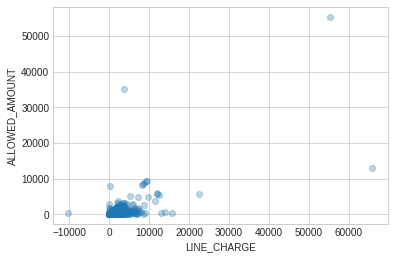

In [20]:
plt.scatter(price_summ_sample_df.dropna().LINE_CHARGE,
            price_summ_sample_df.dropna().ALLOWED_AMOUNT,
            alpha=0.3)
plt.xlabel('LINE_CHARGE')
plt.ylabel('ALLOWED_AMOUNT');

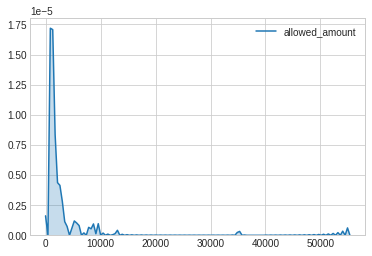

In [21]:
#sns.kdeplot(price_summ_sample_df.dropna().LINE_CHARGE, shade=True, label="line_charge")
sns.kdeplot(price_summ_sample_df.dropna().ALLOWED_AMOUNT, shade=True, label="allowed_amount")
plt.legend();

#### Notes

* standard deviation scatterplot
* weighted density

### Plots by Procedure

In [22]:
top_proc_list=sorted(list(top_proc_df.dropna().PROCEDURE.unique()))

In [23]:
dropdown_proc = widgets.Dropdown(options = top_proc_list)

output_proc = widgets.Output()  

def dropdown_proc_eventhandler(change):
    output_proc.clear_output()
    temp_df=pull_snfdb(db=db1, where='procedure='+"'"+change.new.strip('"')+"'")
    display(temp_df.head())
    proc_description=temp_df["CODE_DESCRIPTION"][:30]
    median_px=np.median(temp_df["ALLOWED_AMOUNT"])
    mean_px=np.mean(temp_df["ALLOWED_AMOUNT"])
    percentile_5=np.percentile(temp_df["ALLOWED_AMOUNT"],5)
    percentile_10=np.percentile(temp_df["ALLOWED_AMOUNT"],10)
    percentile_90=np.percentile(temp_df["ALLOWED_AMOUNT"],90)
    percentile_95=np.percentile(temp_df["ALLOWED_AMOUNT"],95)
    median_px_trim=np.median(temp_df.loc[(temp_df["ALLOWED_AMOUNT"]>percentile_5)&(temp_df["ALLOWED_AMOUNT"]<percentile_95),"ALLOWED_AMOUNT"])
    mean_px_trim=np.mean(temp_df.loc[(temp_df["ALLOWED_AMOUNT"]>percentile_5)&(temp_df["ALLOWED_AMOUNT"]<percentile_95),"ALLOWED_AMOUNT"])
    print(temp_df.shape)
    print(temp_df["CODE_DESCRIPTION"][0])
    print(pull_df_dist_summ(temp_df[temp_df.ALLOWED_AMOUNT>=0].dropna().ALLOWED_AMOUNT))
    print(pull_df_dist_summ(temp_df[temp_df.LINE_CHARGE>=0].dropna().LINE_CHARGE))
    trunc_df=temp_df[(temp_df.ALLOWED_AMOUNT>=0) & 
                     (temp_df.ALLOWED_AMOUNT<=np.percentile(temp_df.dropna().ALLOWED_AMOUNT,75))]

    sns.distplot(trunc_df.dropna().ALLOWED_AMOUNT, hist_kws={'weights':trunc_df.dropna().PATIENT_COUNT},
                hist=False,label="allowed_amount")
    
    trunc_df=temp_df[(temp_df.LINE_CHARGE>=0) & 
                     (temp_df.LINE_CHARGE<=np.percentile(temp_df.dropna().LINE_CHARGE,75))]
    
    dist_vals=sns.distplot(trunc_df.dropna().LINE_CHARGE, hist_kws={'weights':trunc_df.dropna().PATIENT_COUNT},
                hist=False, label="line_charge").get_lines()[0].get_data()
    #plt.plot([median_px, median_px], [0, max(dist_vals[1])], color="red")
    #plt.plot([median_px_trim, median_px_trim], [0, max(dist_vals[1])], color="green")
    #plt.plot([mean_px, mean_px], [0, max(dist_vals[1])], color="black")
    #plt.plot([mean_px_trim, mean_px_trim], [0, max(dist_vals[1])], color="black")
    plt.legend();

temp_df=dropdown_proc.observe(dropdown_proc_eventhandler, names='value')

Dropdown(options=('"00"', '"1036F"', '"1159F"', '"1160F"', '"3008F"', '"3074F"', '"3078F"', '"3079F"', '"36415…

select * 
         from "SANDBOX_KRAO"."EDA"."PROCEDURE_COST_SUMMARY_TABLE"
         where procedure='1159F' 


,LINE_CHARGE,ALLOWED_AMOUNT,PROCEDURE,CODE_DESCRIPTION,PATIENT_COUNT,ENCOUNTER_KEY_COUNT
0,30.0,NaN,"""1159F""",Medication list documented in medical record (...,24754,24754
1,NaN,5.00,"""1159F""",Medication list documented in medical record (...,1964,1964
2,190.0,190.00,"""1159F""",Medication list documented in medical record (...,390,390
3,1.0,1.00,"""1159F""",Medication list documented in medical record (...,92,92
4,150.0,80.58,"""1159F""",Medication list documented in medical record (...,91,91


/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(28103, 6)
Medication list documented in medical record (coa)
    min   perc5  perc10  perc25  median        mean   perc75  perc90   perc95  \
0  0.01  26.588  62.338  103.71  168.89  223.678621  250.035  351.94  470.314   

        max  
0  18667.54  
   min  perc5  perc10  perc25  median        mean  perc75  perc90  perc95  \
0  0.0   13.0   128.0   235.0   404.0  470.313231   608.0   890.1  1105.0   

       max  
0  18522.0  


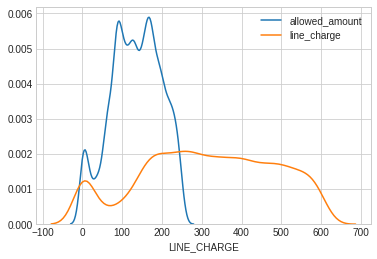

In [24]:
display(dropdown_proc)

In [22]:
def pull_proc_price(proc_code, db=db1):
    temp_df=pull_snfdb(db, where='procedure='+"'"+proc_code+"'")
    return temp_df

In [24]:
def filter_price_df(df=df,amt_col_name="ALLOWED_AMOUNT",min_amt=0,max_amt=10000000,min_amt_count=30):
    temp_df=df.dropna()
    temp_df=temp_df[(temp_df[amt_col_name]>min_amt) & (temp_df[amt_col_name]<max_amt)]
    if len(temp_df)<min_amt_count:
        return None
    else:
        return temp_df

In [25]:
def pull_filtered_proc_price_df(proc_code, db=db1):
    temp_df=pull_proc_price(proc_code, db)
    return filter_price_df(temp_df)
    

In [26]:
temp_df=pull_filtered_proc_price_df('36415')

select * 
         from "SANDBOX_KRAO"."EDA"."PROCEDURE_COST_SUMMARY_TABLE"
         where procedure='36415' 


In [37]:
proc_description=temp_df["CODE_DESCRIPTION"][:30]
median_px=np.median(temp_df["ALLOWED_AMOUNT"])
mean_px=np.mean(temp_df["ALLOWED_AMOUNT"])
percentile_5=np.percentile(temp_df["ALLOWED_AMOUNT"],5)
percentile_10=np.percentile(temp_df["ALLOWED_AMOUNT"],10)
percentile_90=np.percentile(temp_df["ALLOWED_AMOUNT"],90)
percentile_95=np.percentile(temp_df["ALLOWED_AMOUNT"],95)
median_px_trim=np.median(temp_df.loc[(temp_df["ALLOWED_AMOUNT"]>percentile_5)&(temp_df["ALLOWED_AMOUNT"]<percentile_95),"ALLOWED_AMOUNT"])
mean_px_trim=np.mean(temp_df.loc[(temp_df["ALLOWED_AMOUNT"]>percentile_5)&(temp_df["ALLOWED_AMOUNT"]<percentile_95),"ALLOWED_AMOUNT"])

In [ ]:
temp_df=pull_filtered_proc_price_df('36415')


proc_description=temp_df["CODE_DESCRIPTION"][:30]
median_px=np.median(temp_df["ALLOWED_AMOUNT"])
mean_px=np.mean(temp_df["ALLOWED_AMOUNT"])
percentile_5=np.percentile(temp_df["ALLOWED_AMOUNT"],5)
percentile_10=np.percentile(temp_df["ALLOWED_AMOUNT"],10)
percentile_90=np.percentile(temp_df["ALLOWED_AMOUNT"],90)
percentile_95=np.percentile(temp_df["ALLOWED_AMOUNT"],95)
median_px_trim=np.median(temp_df.loc[(temp_df["ALLOWED_AMOUNT"]>percentile_5)&(temp_df["ALLOWED_AMOUNT"]<percentile_95),"ALLOWED_AMOUNT"])
mean_px_trim=np.mean(temp_df.loc[(temp_df["ALLOWED_AMOUNT"]>percentile_5)&(temp_df["ALLOWED_AMOUNT"]<percentile_95),"ALLOWED_AMOUNT"])

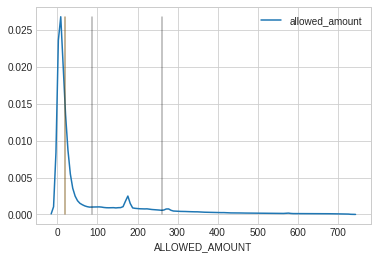

In [72]:
dist_vals=sns.distplot(temp_df.loc[temp_df["ALLOWED_AMOUNT"]<percentile_95,"ALLOWED_AMOUNT"],
                       hist=False,label="allowed_amount").get_lines()[0].get_data()
#test=sns.distplot(temp_df.loc[temp_df["ALLOWED_AMOUNT"]<percentile_95,"ALLOWED_AMOUNT"],hist=False,label="allowed_amount").get_lines()[0].get_data()
plt.plot([median_px, median_px], [0, max(dist_vals[1])], color="red", alpha=0.3)
plt.plot([median_px_trim, median_px_trim], [0, max(dist_vals[1])], color="green", alpha=0.3)
plt.plot([mean_px, mean_px], [0, max(dist_vals[1])], color="black", alpha=0.3)
plt.plot([mean_px_trim, mean_px_trim], [0, max(dist_vals[1])], color="black", alpha=0.3);

In [68]:
max(dist_vals[1])

0.026794826217983802

In [27]:
temp_df.head()

,LINE_CHARGE,ALLOWED_AMOUNT,PROCEDURE,CODE_DESCRIPTION,PATIENT_COUNT,ENCOUNTER_KEY_COUNT
2,0.0,4.07,"""36415""",Insertion of needle into vein for collection o...,415,415
3,8.0,6.72,"""36415""",Insertion of needle into vein for collection o...,779,779
4,7.0,8.64,"""36415""",Insertion of needle into vein for collection o...,4,4
6,3.0,3.03,"""36415""",Insertion of needle into vein for collection o...,3533,3533
7,12.0,11.57,"""36415""",Insertion of needle into vein for collection o...,515,515


In [45]:
temp_px_df=filter_prices(df)

In [43]:
temp_px_df.describe()

,LINE_CHARGE,ALLOWED_AMOUNT,PATIENT_COUNT,ENCOUNTER_KEY_COUNT
count,729837.000000,729837.000000,7.298370e+05,7.298370e+05
mean,524.077482,260.428635,4.683407e+01,4.683407e+01
std,2903.033362,1922.296792,5.890634e+03,5.890634e+03
min,-94751.000000,0.010000,1.000000e+00,1.000000e+00
25%,16.000000,7.080000,1.000000e+00,1.000000e+00
50%,38.000000,19.660000,1.000000e+00,1.000000e+00
75%,210.000000,147.250000,2.000000e+00,2.000000e+00
max,266553.000000,241947.500000,4.760027e+06,4.760027e+06


In [37]:
amt_col_name="ALLOWED_AMOUNT"
min_amt=0
max_amt=10000000
min_amt_count=30
temp_df=df.dropna()
temp_df=temp_df[(df[amt_col_name]>min_amt) & (df[amt_col_name]<max_amt)]
if len(temp_df)<min_at_count:
    return None
else:
    return temp_df

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


SyntaxError: 'return' outside function (<ipython-input-37-abf13277c8ca>, line 8)

In [36]:
len(temp_df)

729837

In [34]:
df.describe()

,LINE_CHARGE,ALLOWED_AMOUNT,PATIENT_COUNT,ENCOUNTER_KEY_COUNT
count,8.139490e+05,746722.000000,8.308350e+05,8.308350e+05
mean,2.266327e+11,262.664496,1.746306e+02,1.746306e+02
std,2.044660e+14,1935.097729,3.083278e+04,3.083278e+04
min,-9.475100e+04,0.010000,1.000000e+00,1.000000e+00
25%,1.800000e+01,7.230000,1.000000e+00,1.000000e+00
50%,4.500000e+01,20.350000,1.000000e+00,1.000000e+00
75%,4.570000e+02,150.040000,2.000000e+00,2.000000e+00
max,1.844674e+17,241947.500000,2.320576e+07,2.320576e+07


In [35]:
temp_df.describe()

,LINE_CHARGE,ALLOWED_AMOUNT,PATIENT_COUNT,ENCOUNTER_KEY_COUNT
count,729837.000000,729837.000000,7.298370e+05,7.298370e+05
mean,524.077482,260.428635,4.683407e+01,4.683407e+01
std,2903.033362,1922.296792,5.890634e+03,5.890634e+03
min,-94751.000000,0.010000,1.000000e+00,1.000000e+00
25%,16.000000,7.080000,1.000000e+00,1.000000e+00
50%,38.000000,19.660000,1.000000e+00,1.000000e+00
75%,210.000000,147.250000,2.000000e+00,2.000000e+00
max,266553.000000,241947.500000,4.760027e+06,4.760027e+06


In [26]:
dropdown_proc = widgets.Dropdown(options = top_proc_list)

output_proc = widgets.Output()  

def dropdown_proc_eventhandler(change):
    output_proc.clear_output()
    temp_df=pull_snfdb(db=db1, where='procedure='+"'"+change.new.strip('"')+"'")
    display(temp_df.head())
    print(temp_df.shape)
    print(temp_df["CODE_DESCRIPTION"][0])
    sns.distplot(temp_df.dropna().LINE_CHARGE, hist_kws={'weights':temp_df.dropna().PATIENT_COUNT},
                label="line_charge")
    sns.distplot(temp_df.dropna().ALLOWED_AMOUNT, hist_kws={'weights':temp_df.dropna().PATIENT_COUNT},
                label="allowed_amount")
    plt.legend();
    
dropdown_proc.observe(dropdown_proc_eventhandler, names='value')

NameError: name 'temp_df' is not defined

In [200]:
temp_df=pull_snfdb(db=db1, where='procedure='+"'"+'99204'+"'")

select * 
         from "SANDBOX_KRAO"."EDA"."PROCEDURE_COST_SUMMARY_TABLE"
         where procedure='99204' 


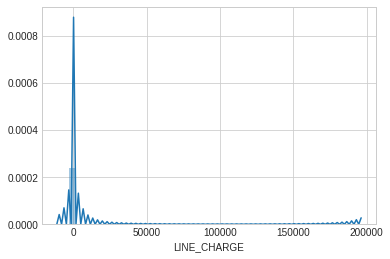

In [212]:
sns.distplot(temp_df.dropna().LINE_CHARGE, hist_kws={'weights':temp_df.dropna().PATIENT_COUNT},
             label="line_charge");

In [31]:
temp_df.describe

<bound method NDFrame.describe of    line_charge_min  line_charge_10percentile  line_charge_25percentile  \
0       -9588820.0                  43.01231                155.257109   

   line_charge_median  line_charge_average  line_charge_75percentile  \
0        1.289212e+11               777.28                3841.96358   

   line_charge_90percentile  line_charge_max  
0              13973.693063     1.844674e+17  >

In [22]:
temp_df.columns=[x+'_'+y for y in name_list]

In [23]:
describecolumns

Index(['line_charge_min', 'line_charge_10percentile',
       'line_charge_25percentile', 'line_charge_median', 'line_charge_average',
       'line_charge_75percentile', 'line_charge_90percentile',
       'line_charge_max'],
      dtype='object')

In [19]:
name_list

['min',
 '10percentile',
 '25percentile',
 'median',
 'average',
 '75percentile',
 '90percentile',
 'max']

In [21]:
[x+'_'+y for y in name_list]

['line_charge_min',
 'line_charge_10percentile',
 'line_charge_25percentile',
 'line_charge_median',
 'line_charge_average',
 'line_charge_75percentile',
 'line_charge_90percentile',
 'line_charge_max']

In [83]:
import pandas as pd
import numpy as np
url = "https://data.london.gov.uk/download/number-international-visitors-london/b1e0f953-4c8a-4b45-95f5-e0d143d5641e/international-visitors-london-raw.csv"
df_london = pd.read_csv(url,encoding= 'unicode_escape')

In [84]:
ALL = 'ALL'
def unique_sorted_values_plus_ALL(array):
    unique = array.unique().tolist()
    unique.sort()
    unique.insert(0, ALL)
    return unique

In [85]:
dropdown_year = widgets.Dropdown(options =    unique_sorted_values_plus_ALL(df_london.year))
def dropdown_year_eventhandler(change):
    if (change.new == ALL):
        display(df_london)
    else:
        display(df_london[df_london.year == change.new])
                
dropdown_year.observe(dropdown_year_eventhandler, names='value')

In [86]:
display(dropdown_year)

Dropdown(options=('ALL', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012…

,year,quarter,market,dur_stay,mode,purpose,area,Visits (000s),Spend (£m),Nights (000s),sample
3397,2003,January-March,Belgium,1-3 nights,Air,Holiday,LONDON,6.090235,1.806471,16.147360,8
3398,2003,January-March,Belgium,1-3 nights,Air,Business,LONDON,9.704368,2.003923,13.603636,14
3399,2003,January-March,Belgium,1-3 nights,Air,VFR,LONDON,3.883525,1.016653,9.254078,7
3400,2003,January-March,Belgium,1-3 nights,Air,Miscellaneous,LONDON,2.388222,0.806961,3.505708,2
3401,2003,January-March,Belgium,1-3 nights,Sea,Holiday,LONDON,2.920971,0.366634,5.776147,3
...,...,...,...,...,...,...,...,...,...,...,...
6632,2003,October-December,Other Africa,8-14 nights,Air,VFR,LONDON,0.645745,0.072182,3.300991,2
6633,2003,October-December,Other Africa,15+ nights,Air,Holiday,LONDON,1.014089,3.297649,24.187850,4
6634,2003,October-December,Other Africa,15+ nights,Air,Business,LONDON,1.458041,2.448336,43.745883,3
6635,2003,October-December,Other Africa,15+ nights,Air,VFR,LONDON,1.239591,0.922923,37.191634,5


### NOTES

-Create Sampling